<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/Style_Transfering_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Trainsfering project

In [258]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

# for image saving
import glob
import re
from PIL import Image
from IPython.display import Image, display


# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-258-0cbcf69594ba>:26: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Import VGG19 and freeze all layers

In [259]:
# import the model
vggnet = torchvision.models.vgg19(pretrained=True)

# freeze all layers
for p in vggnet.parameters():
    p.requires_grad = False

# set to evaluation mode
vggnet.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [260]:
# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

vggnet.to(device);

# Import two images

In [261]:
# Wirte URL of image or filename here
img4content = imread('Olek.png')
img4style   = imread('van.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

<ipython-input-261-9c86e8a52d29>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('Olek.png')
<ipython-input-261-9c86e8a52d29>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style   = imread('van.jpg')


In [262]:
## These images are really large, which will make training take a long time.

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

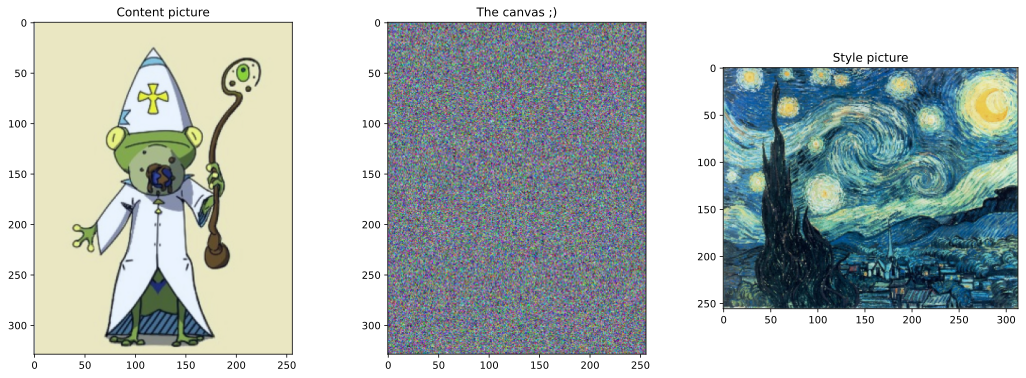

In [263]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('The canvas ;)')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

# Functions to extract image feature map activations

In [264]:
# A function that returns feature maps

def getFeatureMapActs(img,net):

  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):

    # process the image through this layer
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1

  return featuremaps,featurenames

In [265]:
# A function that returns the Gram matrix of the feature activation map
def gram_matrix(M):

  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

In [266]:
# inspect the output of the function
featmaps,featnames = getFeatureMapActs(img4content,vggnet)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 329, 256])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 329, 256])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 164, 128])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 164, 128])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 82, 64])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 82, 64])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 82, 64])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 82, 64])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 41, 32])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 41, 32])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 41, 32])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 41, 32])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 20, 16])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 20, 16])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 20, 16])
Feature map "ConvLayer_15" is size torch.Siz

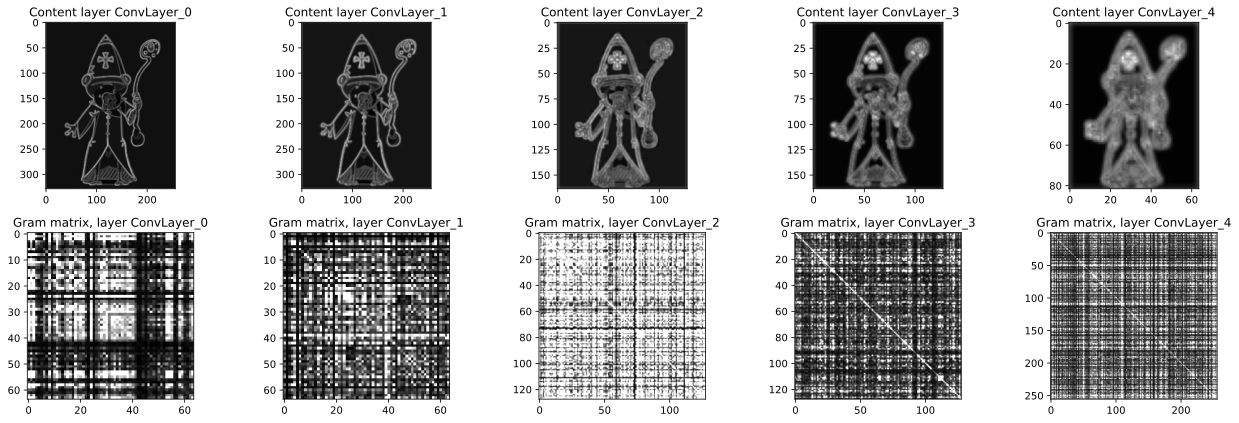

In [267]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,vggnet)

fig,axs = plt.subplots(2, 5, figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

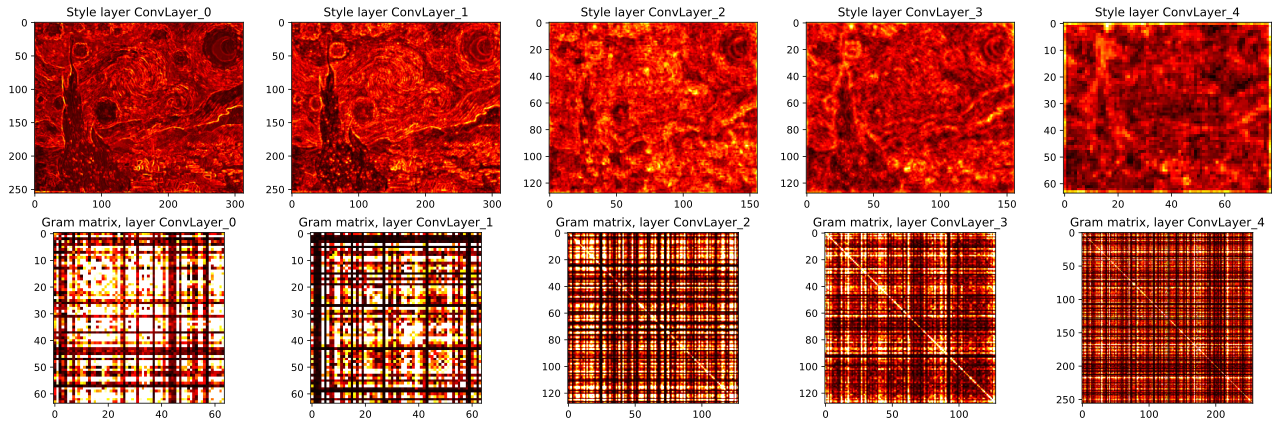

In [268]:

# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='hot')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='hot',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

# Now for the transfer

In [269]:
# which layers to use
layers4content = [ 'ConvLayer_1','ConvLayer_4' ]
layers4style   = [ 'ConvLayer_0','ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4' ]
weights4style  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ]

In [270]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 2e6

# number of epochs to train
numepochs = 2000

# number of images in gif
ticks = np.linspace(0, numepochs, 23, dtype=int)
cur_image = 0

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)

losses = np.zeros((numepochs, 2))

for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

  losses[epochi, 0] = contentLoss
  losses[epochi, 1] = styleLoss

  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()

  if epochi in ticks:
    pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
    pic = Image.fromarray((pic * 255).astype('uint8'))
    pic.save(f"animation/pic{cur_image}.png")
    cur_image += 1


AttributeError: ignored

In [ ]:
# Directory where your images are located
image_dir = "animation/"

# List all image files in the directory and sort them by name
image_files = sorted(glob.glob(f"{image_dir}pic*.png"))

# Define a function to extract the number from the file path
def extract_number(path):
    match = re.search(r'\d+', path)
    if match:
        return int(match.group())
    return -1  # Return -1 if no number is found

# Sort the list of file paths based on the extracted numbers
sorted_file_paths = sorted(image_files, key=extract_number)
print(sorted_file_paths)
# Create a list to store the images
images = []

# Load each image and append it to the list
for image_file in sorted_file_paths:
    img = Image.open(image_file)
    images.append(img)

# Save the GIF
output_gif = "animation/output.gif"
images[-1].save(output_gif, save_all=True, append_images=images, duration=300, loop=0)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5) )

ax[0].plot(losses[:,0], 's-', label='content')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (RMS)')
ax[0].set_title('content loss')

ax[1].plot(losses[:,1], 's-', label='style')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss (RMS)')
ax[1].set_title('style loss')

plt.show()

# Let's have a looksie!

In [ ]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
print(type(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

display(Image(filename='/animation/output.gif'))